# Deep Funding Mini-Contest Predictions
This notebook walks through the process of loading and analyzing the Deep Funding Mini-Contest.


## Setup
First, let's import our required libraries and set up our environment.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from pathlib import Path
import subprocess
import os

# Create data directory if it doesn't exist
Path("data").mkdir(exist_ok=True)


## Load Dataset
Now let's load the dataset and examine its structure.

In [2]:
# Load dataset
repo_dir = Path("./dataset")
dataset_path = repo_dir / "dataset.csv"
df = pd.read_csv(dataset_path)

# Display basic information
print("Dataset Info:")
print(df.info())

print("\nFirst few rows:")
print(df.head())

print("\nBasic statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20958 entries, 0 to 20957
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                20958 non-null  int64  
 1   project_a         20958 non-null  object 
 2   project_b         20958 non-null  object 
 3   weight_a          20958 non-null  float64
 4   weight_b          20958 non-null  float64
 5   total_amount_usd  20958 non-null  int64  
 6   funder            20958 non-null  object 
 7   quarter           20958 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 1.3+ MB
None

First few rows:
    id                           project_a  \
0  715    https://github.com/mochajs/mocha   
1  716    https://github.com/mochajs/mocha   
2  717  https://github.com/chzyer/readline   
3  718  https://github.com/chzyer/readline   
4  719  https://github.com/chzyer/readline   

                            project_b  weight_a

## Analyze Projects
Let's identify unique projects and basic statistics.

In [3]:
# Get unique projects from both columns
unique_projects = set(df['project_a'].unique()) | set(df['project_b'].unique())
projects = sorted(list(unique_projects))

print(f"Total number of unique projects: {len(projects)}")
print(f"Total number of comparisons: {len(df)}")

# Weight statistics
print("\nWeight Distribution:")
print(f"Average weight_a: {df['weight_a'].mean():.4f}")
print(f"Standard deviation: {df['weight_a'].std():.4f}")
print(f"Min weight_a: {df['weight_a'].min():.4f}")
print(f"Max weight_a: {df['weight_a'].max():.4f}")

Total number of unique projects: 104
Total number of comparisons: 20958

Weight Distribution:
Average weight_a: 0.4873
Standard deviation: 0.3887
Min weight_a: 0.0000
Max weight_a: 1.0000


## Visualize Distribution
Let's create visualizations to understand the weight distribution.

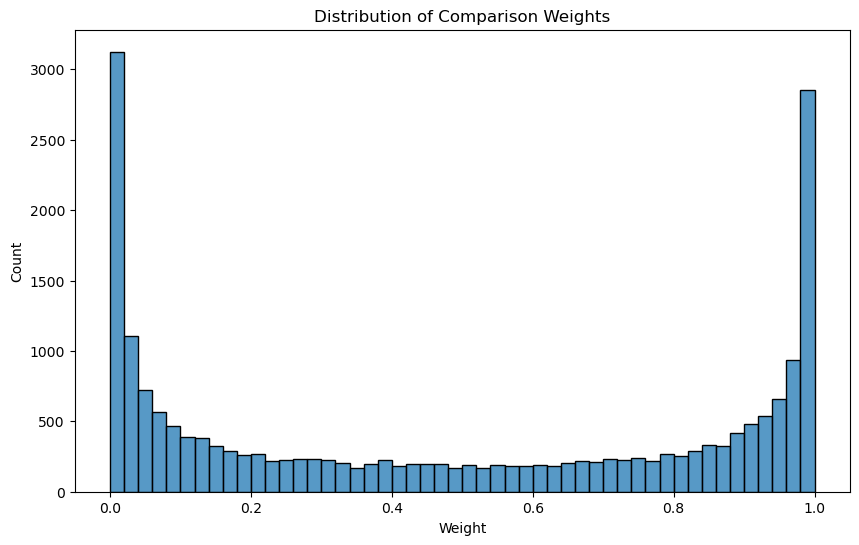

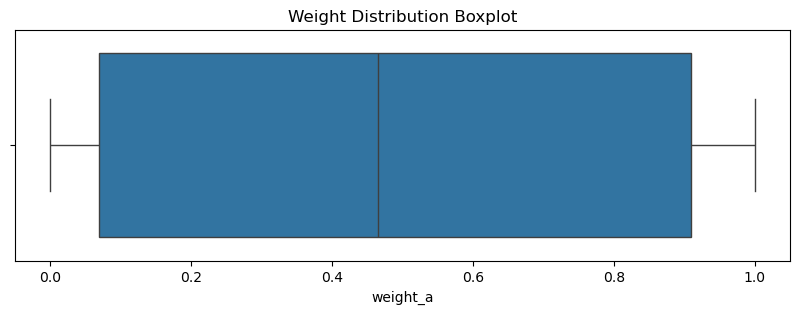

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure style
plt.style.use('default')  # Using default matplotlib style

# Create histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['weight_a'], bins=50)
plt.title('Distribution of Comparison Weights')
plt.xlabel('Weight')
plt.ylabel('Count')
plt.show()

# Create boxplot
plt.figure(figsize=(10, 3))
sns.boxplot(x=df['weight_a'])
plt.title('Weight Distribution Boxplot')
plt.show()


In [5]:
# Save the list of projects
with open('data2/projects.txt', 'w') as f:
    for project in projects:
        f.write(f"{project}\n")

print(f"Saved {len(projects)} projects to data2/projects.txt")


Saved 104 projects to data2/projects.txt


## GitHub Documentation Collection
We'll collect documentation in steps, caching our progress along the way.

In [6]:
!pip install GitPython 

In [7]:
# Import required libraries
import requests
import base64
from pathlib import Path
import json
from tqdm import tqdm
import time
import tempfile
import glob
import os
from git import Repo
# Create cache directory if it doesn't exist
cache_dir = Path("data2")
cache_dir.mkdir(exist_ok=True)


## GitHub Authentication
We need to authenticate with GitHub to get higher rate limits. You can create a personal access token at:
https://github.com/settings/tokens

Make sure to give it at least 'repo' and 'read:packages' permissions.

In [8]:
# Set up GitHub authentication
import os
from getpass import getpass

# Try to get token from environment variable first
github_token = os.environ.get('GITHUB_TOKEN')

# If not in environment, ask for it
if not github_token:
    github_token = getpass("Enter your GitHub Personal Access Token: ")

# Set up headers with authentication
headers = {
    'Accept': 'application/vnd.github.v3+json',
    'Authorization': f'token {github_token}'
}

# Test the authentication
test_response = requests.get('https://api.github.com/rate_limit', headers=headers)
if test_response.status_code == 200:
    limits = test_response.json()['rate']
    print(f"Authentication successful!")
    print(f"Rate limit: {limits['limit']}")
    print(f"Remaining: {limits['remaining']}")
    print(f"Reset time: {pd.Timestamp.fromtimestamp(limits['reset'])}")
else:
    print("Authentication failed!")
    print(test_response.json())

Enter your GitHub Personal Access Token:  ········


Authentication successful!
Rate limit: 5000
Remaining: 4996
Reset time: 2025-01-15 15:51:17


In [9]:
# Helper function to get README through GitHub API
def get_readme(repo_url, headers=None):
    """Fetches README content from GitHub API"""
    # Extract owner and repo from github URL
    _, _, _, owner, repo = repo_url.rstrip('/').split('/')
    
    # List of possible README filenames
    readme_names = ['README.md', 'Readme.md', 'readme.md', 'README.markdown', 'README.rst']
    
    headers = headers or {'Accept': 'application/vnd.github.v3+json'}
    
    for name in readme_names:
        try:
            url = f'https://api.github.com/repos/{owner}/{repo}/contents/{name}'
            response = requests.get(url, headers=headers)
            
            if response.status_code == 200:
                content = base64.b64decode(response.json()['content']).decode('utf-8')
                return content
                
        except Exception as e:
            continue
    
    return None


## Step 1: Collect READMEs via GitHub API
First, we'll try to get READMEs through the GitHub API for all projects.


In [10]:
# Try to load existing documentation
docs_cache_path = cache_dir / "github_docs.json"
if docs_cache_path.exists():
    with open(docs_cache_path, 'r', encoding='utf-8') as f:
        docs = json.load(f)
    print(f"Loaded {len(docs)} documents from cache")
else:
    docs = {}
    print("Starting fresh documentation collection")

# Collect READMEs for projects not in cache
projects_to_fetch = [p for p in projects if p not in docs]
print(f"Fetching READMEs for {len(projects_to_fetch)} projects")

for project in tqdm(projects_to_fetch, desc="Fetching READMEs"):
    readme = get_readme(project)
    if readme:
        docs[project] = readme
        # Save progress after each successful fetch
        with open(docs_cache_path, 'w', encoding='utf-8') as f:
            json.dump(docs, f, ensure_ascii=False, indent=2)
    time.sleep(1)  # Rate limiting

missing_projects = set(projects) - set(docs.keys())
print(f"\nMissing documentation for {len(missing_projects)} projects")

Loaded 104 documents from cache
Fetching READMEs for 0 projects


Fetching READMEs: 0it [00:00, ?it/s]


Missing documentation for 0 projects


In [11]:
missing_projects

set()

## Step 2: Handle Special Cases
For projects with missing documentation, we'll try special cases first.

In [12]:
# Cell for handling special case files
def get_go_file(repo_url, headers):
    """
    Fetches specific .go files when no README is available
    Args:
        repo_url: GitHub repository URL
        headers: GitHub API headers with authentication
    """
    _, _, _, owner, repo = repo_url.rstrip('/').split('/')
    
    try:
        url = f'https://api.github.com/repos/{owner}/{repo}/contents/iter.go'
        print(f"Trying {url}")
        response = requests.get(url, headers=headers)
        
        if response.status_code == 200:
            return base64.b64decode(response.json()['content']).decode('utf-8')
        elif response.status_code == 403:
            rate_limit = requests.get('https://api.github.com/rate_limit', headers=headers).json()
            print(f"Rate limit exceeded. Resets at: {pd.Timestamp.fromtimestamp(rate_limit['rate']['reset'])}")
        elif response.status_code == 404:
            print(f"File not found at {url}")
        else:
            print(f"Unexpected status code: {response.status_code}")
            print(response.json())
            
    except Exception as e:
        print(f"Error fetching .go file: {e}")
    return None

# Handle iter project specifically
iter_project = "https://github.com/bradfitz/iter"
if iter_project in missing_projects:
    print("Handling iter project specially...")
    content = get_go_file(iter_project, headers=headers)
    if content:
        docs[iter_project] = content
        # Save progress
        with open(docs_cache_path, 'w', encoding='utf-8') as f:
            json.dump(docs, f, ensure_ascii=False, indent=2)
        missing_projects.remove(iter_project)
        print("Successfully added iter.go content")
    else:
        print("Failed to fetch iter.go content")

## Step 3: Try Cloning Repositories
For remaining projects, we'll try cloning the repository and finding any markdown files.


In [13]:
print(f"Attempting to clone {len(missing_projects)} repositories...")

for project in tqdm(missing_projects, desc="Trying repository clones"):
    with tempfile.TemporaryDirectory() as tmp_dir:
        try:
            # Clone repo
            Repo.clone_from(project, tmp_dir, depth=1)
            
            # Find any .md file
            md_files = glob.glob(os.path.join(tmp_dir, '*.md')) + \
                      glob.glob(os.path.join(tmp_dir, '*.markdown'))
            
            if md_files:
                with open(md_files[0], 'r', encoding='utf-8') as f:
                    content = f.read()
                    docs[project] = content
                    # Save progress
                    with open(docs_cache_path, 'w', encoding='utf-8') as f:
                        json.dump(docs, f, ensure_ascii=False, indent=2)
        except Exception as e:
            print(f"\nError with {project}: {e}")
        
        time.sleep(1)  # Rate limiting


Attempting to clone 0 repositories...


Trying repository clones: 0it [00:00, ?it/s]


In [14]:
# Final status report
final_missing = set(projects) - set(docs.keys())
print(f"\nFinal Results:")
print(f"Successfully collected documentation for {len(docs)} projects")
if final_missing:
    print(f"Missing documentation for {len(final_missing)} projects:")
    for project in final_missing:
        print(f"  - {project}")



Final Results:
Successfully collected documentation for 104 projects


## Project Analysis with GPT-4
Now that we have documentation for each project, we'll analyze them using GPT-4 to generate structured ratings across various dimensions.


In [15]:
import os
from openai import OpenAI
import json
from pathlib import Path
from getpass import getpass

# Initialize OpenAI client with your API key
openai_key = os.environ.get('OPENAI_API_KEY')
if not openai_key:
    openai_key = getpass("Enter your OpenAI API key: ")

# Create client without proxy settings
client = OpenAI(
    api_key=openai_key,
    base_url="https://api.openai.com/v1"
)


Enter your OpenAI API key:  ········


## Define Analysis Function
We'll create a function to analyze each project's documentation and return structured ratings.


In [16]:
def analyze_project(readme_content, client):
    """Analyzes project documentation using GPT-4"""
    prompt = """Rate this open source project on each dimension (1-5). Use all available vibes and context to make judgment calls. Being decisive is better than being neutral. Use 3 only when there's truly no signal about a dimension.

Return JSON format:
{
 "technical_complexity": N,  // System complexity 
 "web3_focus": N,           // Blockchain/crypto focus
 "developer_tool": N,       // Developer infrastructure
 "project_maturity": N,     // Production readiness
 "community_size": N,       // Community scale
 "enterprise_ready": N,     // Production/enterprise grade
 "community_engagement": N, // Activity level
 "documentation": N,       // Docs quality
 "code_quality": N,        // Testing/standards
 "status": N,             // Project prestige
 "corporate": N,          // Corporate vs community
 "security": N,           // Security emphasis
 "innovation": N,         // Novel approaches
 "performance": N,        // Speed/efficiency focus
 "modularity": N,         // Reusability
 "accessibility": N,      // New contributor friendly
 "key_features": ["1-3 key features"]
}

Scale:
1 = Very Low
2 = Low
3 = Medium/No Signal
4 = High
5 = Very High

Project Documentation:
""" + readme_content

    response = client.chat.completions.create(
        messages=[{"role": "user", "content": prompt}],
        model="gpt-4o",
        temperature=0.7
    )
    
    return response.choices[0].message.content



## Process Projects
Let's analyze each project and cache the results.


In [17]:
# Path for cached analysis
analysis_cache_path = Path("data2/project_analysis.json")

# Load existing analysis if available
if analysis_cache_path.exists():
    with open(analysis_cache_path, 'r', encoding='utf-8') as f:
        analysis_results = json.load(f)
    print(f"Loaded {len(analysis_results)} existing analyses")
else:
    analysis_results = {}
    print("Starting fresh analysis")

# Process projects not yet analyzed
projects_to_analyze = [p for p in docs.keys() if p not in analysis_results]
print(f"Need to analyze {len(projects_to_analyze)} projects")

for project in tqdm(projects_to_analyze, desc="Analyzing projects"):
    try:
        result = analyze_project(docs[project], client)
        analysis_results[project] = result
        # Save progress after each analysis
        with open(analysis_cache_path, 'w', encoding='utf-8') as f:
            json.dump(analysis_results, f, ensure_ascii=False, indent=2)
        time.sleep(1)  # Rate limiting
    except Exception as e:
        print(f"\nError analyzing {project}: {e}")

Starting fresh analysis
Need to analyze 104 projects


Analyzing projects: 100%|█████████████████████| 104/104 [09:27<00:00,  5.46s/it]


## Clean and Structure Results
Now let's convert the raw GPT responses into structured data we can analyze.


In [18]:
def clean_gpt_response(response):
    """
    Cleans GPT response to extract valid JSON, removing comments
    Args:
        response: Raw GPT-4 response text
    Returns:
        Cleaned JSON string
    """
    import re
    
    # First, find the JSON block if it exists in code blocks
    json_match = re.search(r'```json\s*({.*?})\s*```', response, re.DOTALL)
    if json_match:
        json_str = json_match.group(1)
    else:
        # Otherwise find the first JSON-like object
        json_match = re.search(r'{\s*".*?}', response, re.DOTALL)
        if json_match:
            json_str = json_match.group(0)
        else:
            json_str = response
            
    # Remove line comments after fields
    json_str = re.sub(r',\s*//.*?\n', ',\n', json_str)
    json_str = re.sub(r'//.*?\n', '\n', json_str)
    
    return json_str


# Parse results into DataFrame
project_data = {}
for project, result in analysis_results.items():
    try:
        cleaned_result = clean_gpt_response(result)
        data = json.loads(cleaned_result)
        project_data[project] = data
    except:
        print(f"Error parsing {project}")
        print(cleaned_result)

df_features = pd.DataFrame.from_dict(project_data, orient='index')

# Show basic statistics
print("\nAverage ratings across all dimensions:")
print(df_features.drop('key_features', axis=1).mean().sort_values(ascending=False))

print("\nNumber of projects analyzed:", len(df_features))


Average ratings across all dimensions:
developer_tool          4.605769
code_quality            4.509615
documentation           4.384615
project_maturity        4.317308
modularity              4.153846
status                  4.134615
accessibility           3.942308
performance             3.923077
enterprise_ready        3.807692
community_engagement    3.798077
community_size          3.740385
security                3.721154
technical_complexity    3.586538
innovation              3.538462
corporate               2.634615
web3_focus              1.913462
dtype: float64

Number of projects analyzed: 104


## Prepare Data for XGBoost Analysis
We'll create feature matrices by computing the differences between paired projects.


In [19]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Get feature columns (excluding key_features)
feature_cols = [col for col in df_features.columns if col != 'key_features']

# Prepare feature matrices
X = []  # Feature differences
y = []  # Target values (weight_a)

# For each comparison, compute feature differences
for _, row in df[['project_a', 'project_b', 'weight_a']].iterrows():
    if row['project_a'] in df_features.index and row['project_b'] in df_features.index:
        # Compute feature differences between project pairs
        feature_diff = [
            df_features.loc[row['project_a'], col] - df_features.loc[row['project_b'], col] 
            for col in feature_cols
        ]
        X.append(feature_diff)
        y.append(row['weight_a'])

X = np.array(X)
y = np.array(y)

print(f"Created feature matrix with {len(X)} comparisons and {len(feature_cols)} features")


Created feature matrix with 20958 comparisons and 16 features


## Train XGBoost Model
Now we'll train an XGBoost model to predict project preferences.

In [20]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)

# Make predictions
y_pred = xgb.predict(X_test)

# Evaluate model
print("\nModel Performance:")
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")


Model Performance:
R2 Score: 0.5715
MSE: 0.0640


## Analyze Feature Importance
Let's see which features are most important in determining project preferences.


In [21]:
# Create feature importance DataFrame
importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importances.head(10))


Top 10 Most Important Features:
             feature  importance
5   enterprise_ready    0.236302
2     developer_tool    0.115483
9             status    0.108584
15     accessibility    0.071093
4     community_size    0.051888
11          security    0.051470
14        modularity    0.050666
12        innovation    0.050278
1         web3_focus    0.044776
10         corporate    0.039869


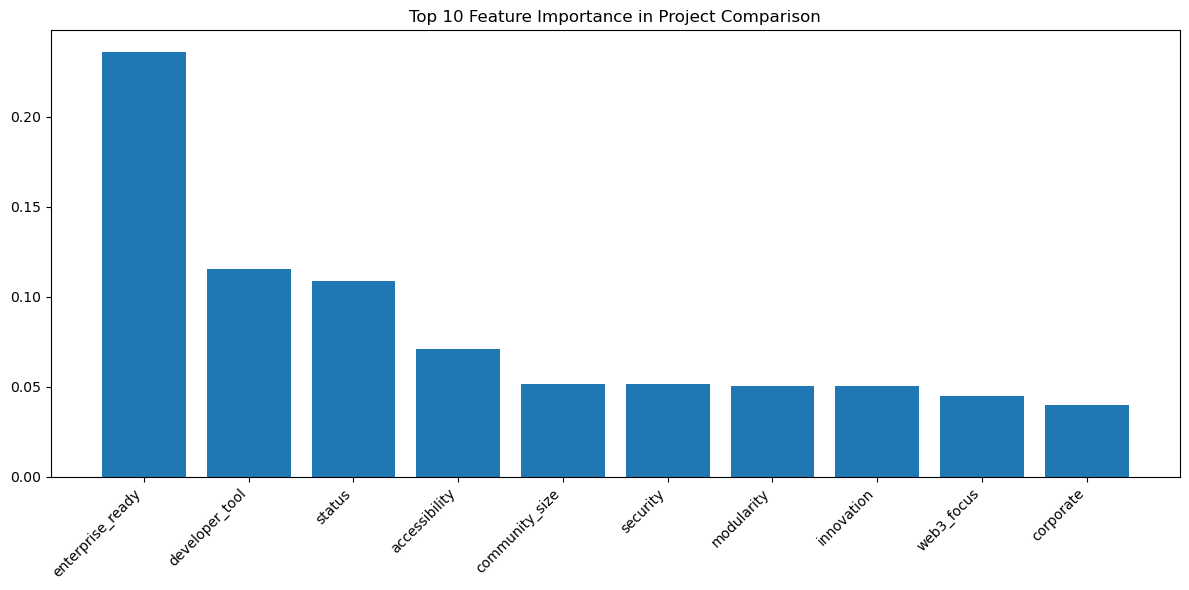

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(importances['feature'][:10], importances['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Feature Importance in Project Comparison')
plt.tight_layout()
plt.show()

In [23]:
# Additional analysis: Feature importance relative to project preferences
# Get the top 5 features
top_features = importances['feature'].head(5).tolist()

# Calculate average difference for highly preferred projects (weight_a > 0.8)
strong_prefs = df[df['weight_a'] > 0.8]
print("\nAnalyzing strong preferences (weight_a > 0.8):")
for feature in top_features:
    avg_diff = []
    for _, row in strong_prefs.iterrows():
        if row['project_a'] in df_features.index and row['project_b'] in df_features.index:
            diff = df_features.loc[row['project_a'], feature] - df_features.loc[row['project_b'], feature]
            avg_diff.append(diff)
    print(f"{feature}: Average difference = {np.mean(avg_diff):.3f}")


Analyzing strong preferences (weight_a > 0.8):
enterprise_ready: Average difference = 0.525
developer_tool: Average difference = 0.035
status: Average difference = 0.482
accessibility: Average difference = 0.027
community_size: Average difference = 0.511


## Analyze XGBoost Predictions
Let's visualize how well our model's predictions match the actual preferences.


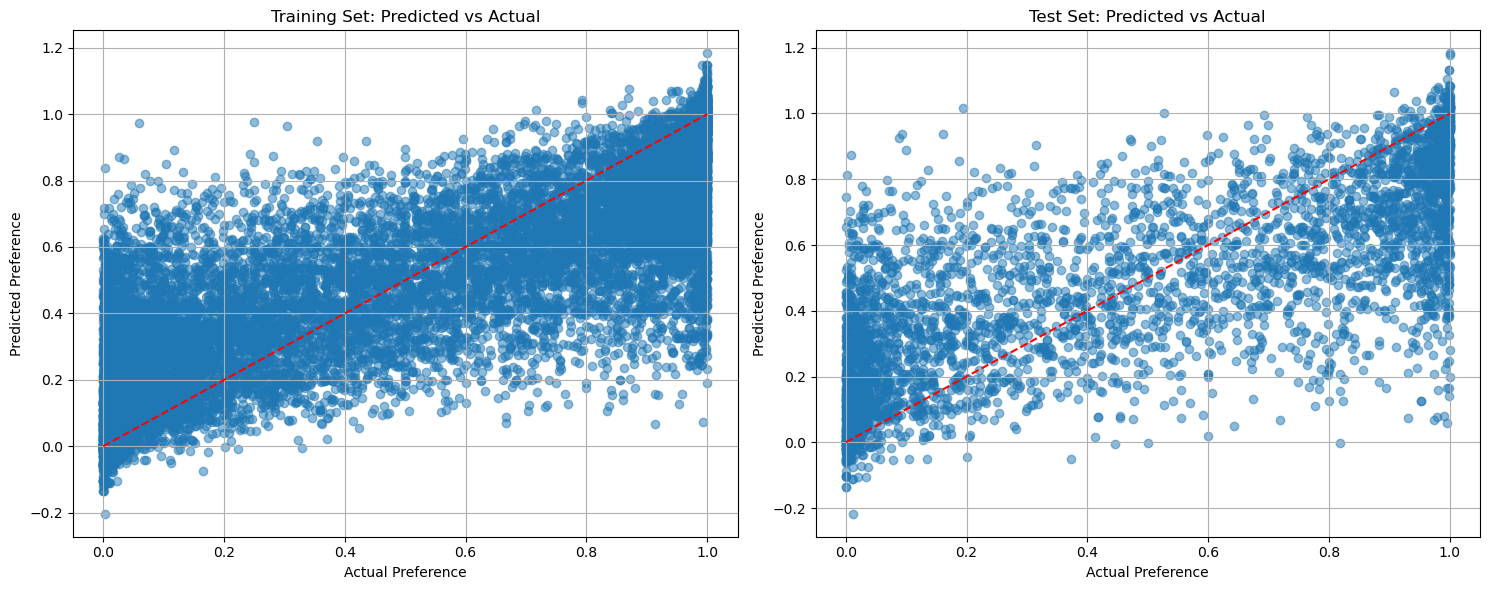

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions for both training and test sets
train_pred = xgb.predict(X_train)
test_pred = xgb.predict(X_test)

# Create subplot with two scatter plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training set plot
ax1.scatter(y_train, train_pred, alpha=0.5)
ax1.plot([0, 1], [0, 1], 'r--')  # Perfect prediction line
ax1.set_xlabel('Actual Preference')
ax1.set_ylabel('Predicted Preference')
ax1.set_title('Training Set: Predicted vs Actual')
ax1.grid(True)

# Test set plot
ax2.scatter(y_test, test_pred, alpha=0.5)
ax2.plot([0, 1], [0, 1], 'r--')  # Perfect prediction line
ax2.set_xlabel('Actual Preference')
ax2.set_ylabel('Predicted Preference')
ax2.set_title('Test Set: Predicted vs Actual')
ax2.grid(True)

plt.tight_layout()
plt.show()

## Analyze Prediction Errors
Let's look at where our model makes the biggest mistakes.


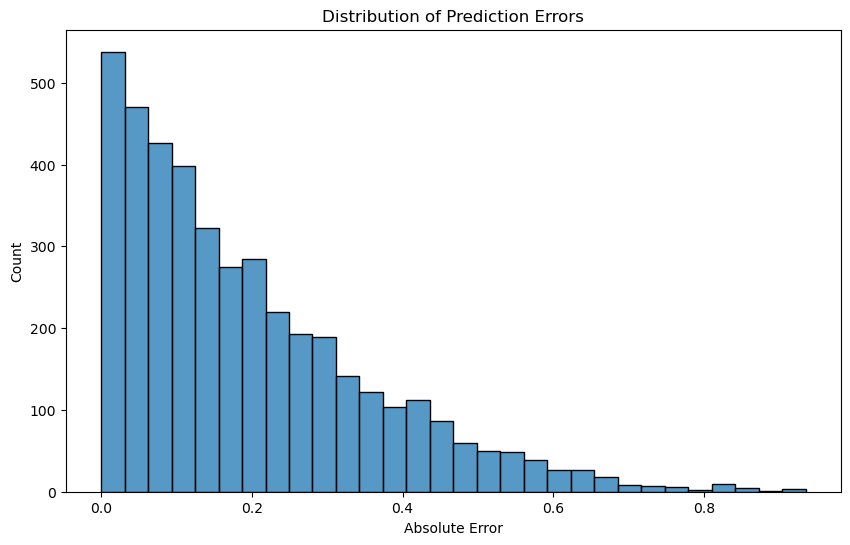


Worst Predictions (largest absolute errors):
      actual  predicted  error
2690   0.995      0.060  0.935
3303   0.990      0.079  0.911
890    0.974      0.068  0.906
2147   0.978      0.076  0.902
154    0.009      0.874  0.865
1742   0.999      0.139  0.860
4022   0.931      0.073  0.858
1747   0.093      0.936  0.843
2961   0.088      0.927  0.839
2909   0.999      0.165  0.834


In [25]:
# Calculate errors
test_errors = pd.DataFrame({
    'actual': y_test,
    'predicted': test_pred,
    'error': np.abs(y_test - test_pred)
})

# Plot error distribution
plt.figure(figsize=(10, 6))
sns.histplot(test_errors['error'], bins=30)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Absolute Error')
plt.ylabel('Count')
plt.show()

# Find the worst predictions
print("\nWorst Predictions (largest absolute errors):")
n_worst = 10
worst_predictions = test_errors.nlargest(n_worst, 'error')
print(worst_predictions.round(3))


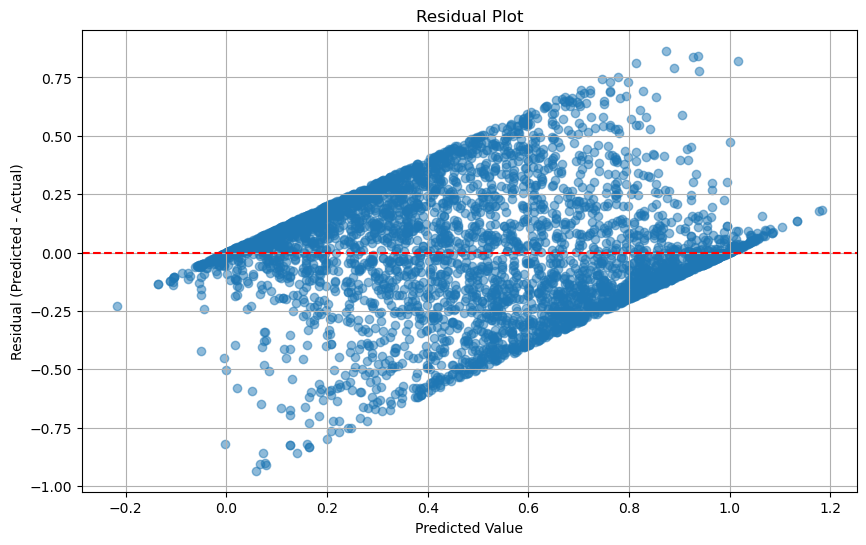


Prediction Statistics:
Mean absolute error: 0.1933
Residuals mean: 0.0015
Residuals std: 0.2530
Predictions > 1: 92
Predictions < 0: 113


In [26]:
# Analyze prediction bias
residuals = test_pred - y_test

plt.figure(figsize=(10, 6))
plt.scatter(test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Value')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

# Print some statistics about the predictions
print("\nPrediction Statistics:")
print(f"Mean absolute error: {np.mean(np.abs(residuals)):.4f}")
print(f"Residuals mean: {np.mean(residuals):.4f}")
print(f"Residuals std: {np.std(residuals):.4f}")
print(f"Predictions > 1: {np.sum(test_pred > 1)}")
print(f"Predictions < 0: {np.sum(test_pred < 0)}")

## Compare Actual vs Predicted Distributions
Let's visualize how well our model captures the true distribution of preferences.


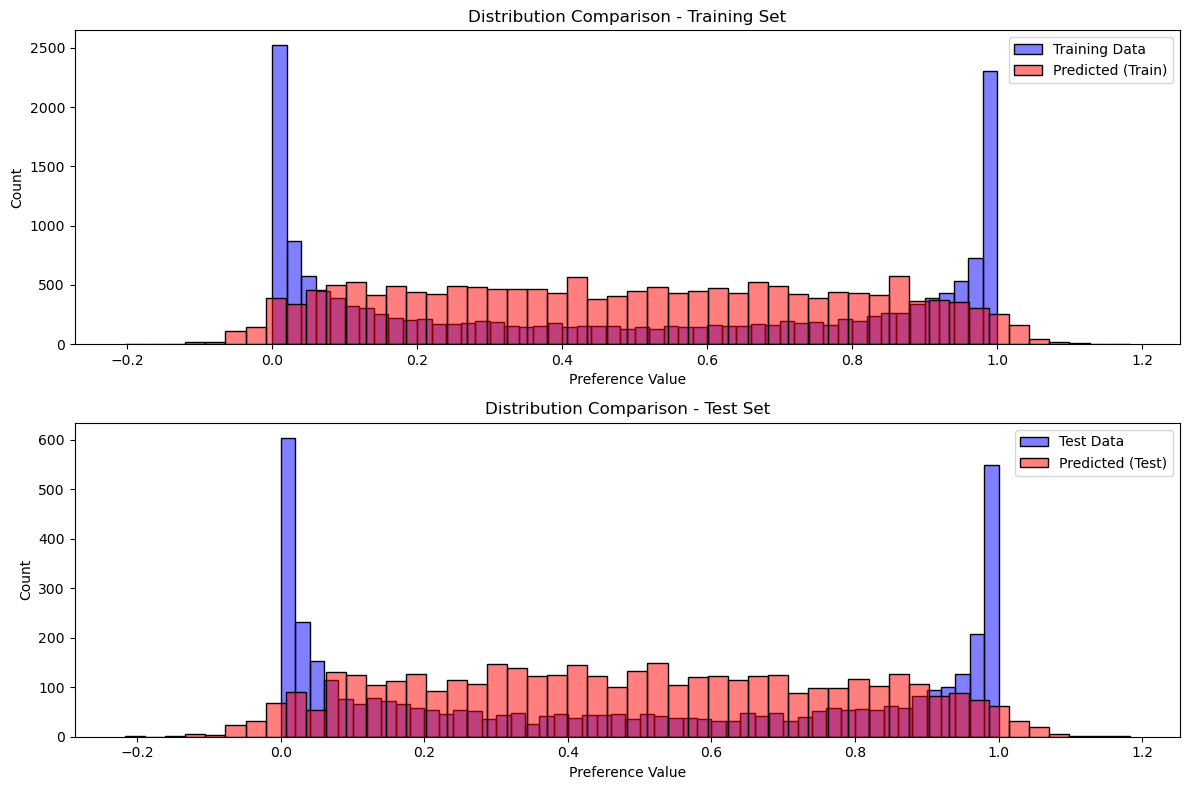


Distribution Statistics:

Training Set:
Actual - Mean: 0.4878, Std: 0.3892
Predicted - Mean: 0.4878, Std: 0.2974

Test Set:
Actual - Mean: 0.4855, Std: 0.3866
Predicted - Mean: 0.4871, Std: 0.2913


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot histograms of actual values
sns.histplot(data=y_train, bins=50, color='blue', alpha=0.5, ax=ax1, label='Training Data')
sns.histplot(data=train_pred, bins=50, color='red', alpha=0.5, ax=ax1, label='Predicted (Train)')
ax1.set_title('Distribution Comparison - Training Set')
ax1.set_xlabel('Preference Value')
ax1.set_ylabel('Count')
ax1.legend()

# Plot histograms of test values
sns.histplot(data=y_test, bins=50, color='blue', alpha=0.5, ax=ax2, label='Test Data')
sns.histplot(data=test_pred, bins=50, color='red', alpha=0.5, ax=ax2, label='Predicted (Test)')
ax2.set_title('Distribution Comparison - Test Set')
ax2.set_xlabel('Preference Value')
ax2.set_ylabel('Count')
ax2.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nDistribution Statistics:")
print("\nTraining Set:")
print(f"Actual - Mean: {y_train.mean():.4f}, Std: {y_train.std():.4f}")
print(f"Predicted - Mean: {train_pred.mean():.4f}, Std: {train_pred.std():.4f}")
print("\nTest Set:")
print(f"Actual - Mean: {y_test.mean():.4f}, Std: {y_test.std():.4f}")
print(f"Predicted - Mean: {test_pred.mean():.4f}, Std: {test_pred.std():.4f}")

## Improve XGBoost Model to Capture Extremes
Let's try adjusting XGBoost parameters to better capture the tails of the distribution.


Distribution Statistics:

Training Set:
Actual - Mean: 0.4878, Std: 0.3892
Predicted - Mean: 0.4879, Std: 0.2612

Test Set:
Actual - Mean: 0.4855, Std: 0.3866
Predicted - Mean: 0.4882, Std: 0.2556


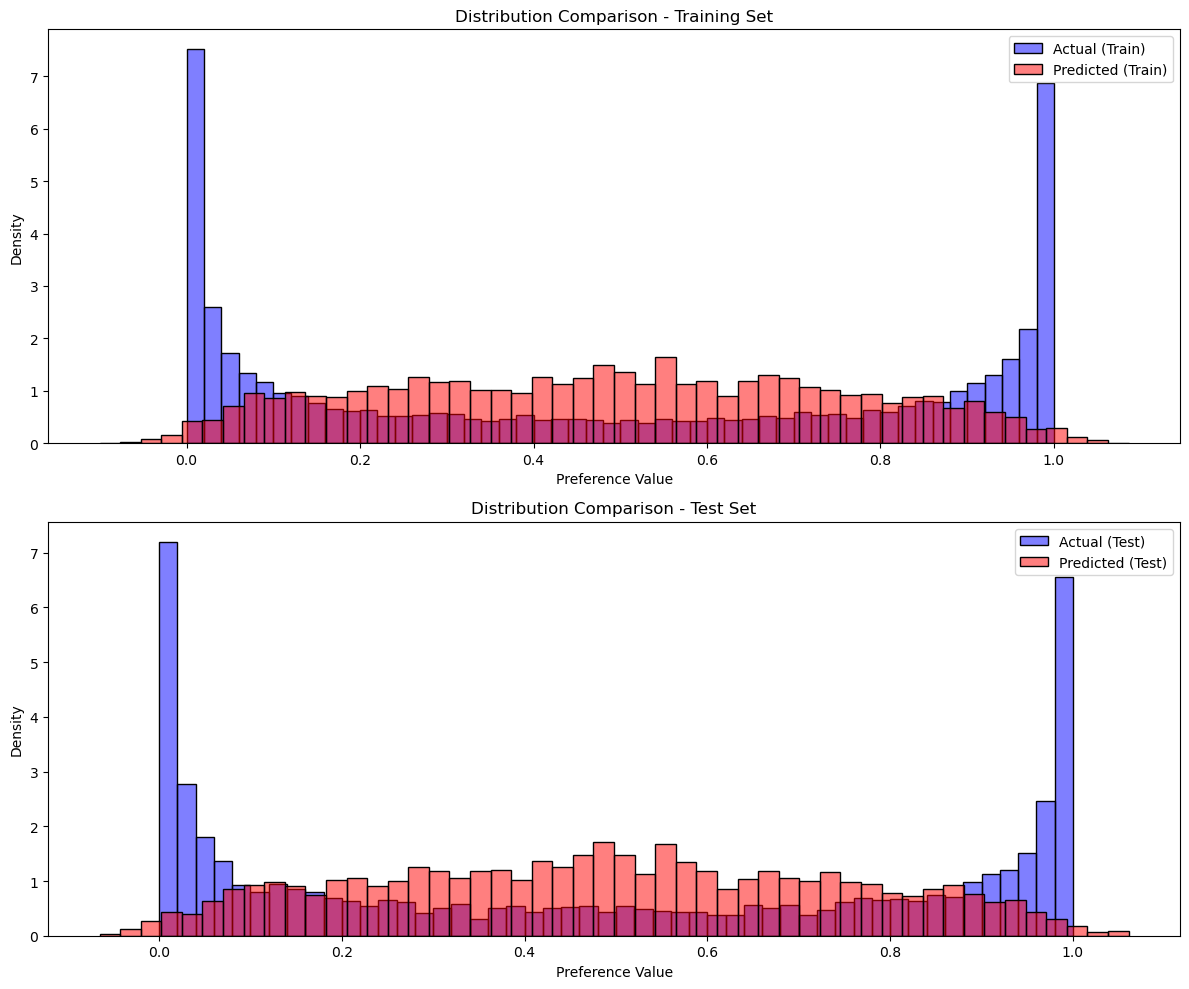


Extreme Value Analysis:

Actual Values:
Train extremes: [3.00283295e-04 9.99689414e-01]
Test extremes: [2.69060253e-04 9.99739555e-01]

Predicted Values:
Train extremes: [0.006146   0.99438167]
Test extremes: [0.00260921 0.98578506]

MSE - Train: 0.0627, Test: 0.0733


In [28]:
# Train XGBoost with modified parameters
xgb_improved = XGBRegressor(
    max_depth=6,              # Deeper trees to capture more complex patterns
    min_child_weight=1,       # Allow smaller leaf nodes
    gamma=0,                  # Minimum loss reduction for split
    subsample=0.8,           # Use 80% of data per tree to reduce overfitting
    colsample_bytree=0.8,    # Use 80% of features per tree
    reg_alpha=0,             # L1 regularization
    reg_lambda=1,            # L2 regularization
    learning_rate=0.05,      # Slower learning rate
    n_estimators=200,        # More trees
    random_state=42
)

# Train the model
xgb_improved.fit(X_train, y_train)

# Get predictions
train_pred_improved = xgb_improved.predict(X_train)
test_pred_improved = xgb_improved.predict(X_test)

# Print distribution statistics
print("Distribution Statistics:")
print("\nTraining Set:")
print(f"Actual - Mean: {y_train.mean():.4f}, Std: {y_train.std():.4f}")
print(f"Predicted - Mean: {train_pred_improved.mean():.4f}, Std: {train_pred_improved.std():.4f}")
print("\nTest Set:")
print(f"Actual - Mean: {y_test.mean():.4f}, Std: {y_test.std():.4f}")
print(f"Predicted - Mean: {test_pred_improved.mean():.4f}, Std: {test_pred_improved.std():.4f}")

# Plot comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Training set
sns.histplot(data=y_train, bins=50, color='blue', alpha=0.5, ax=ax1, label='Actual (Train)', stat='density')
sns.histplot(data=train_pred_improved, bins=50, color='red', alpha=0.5, ax=ax1, label='Predicted (Train)', stat='density')
ax1.set_title('Distribution Comparison - Training Set')
ax1.set_xlabel('Preference Value')
ax1.set_ylabel('Density')
ax1.legend()

# Test set
sns.histplot(data=y_test, bins=50, color='blue', alpha=0.5, ax=ax2, label='Actual (Test)', stat='density')
sns.histplot(data=test_pred_improved, bins=50, color='red', alpha=0.5, ax=ax2, label='Predicted (Test)', stat='density')
ax2.set_title('Distribution Comparison - Test Set')
ax2.set_xlabel('Preference Value')
ax2.set_ylabel('Density')
ax2.legend()

plt.tight_layout()
plt.show()

# Analyze extreme predictions
print("\nExtreme Value Analysis:")
print("\nActual Values:")
print(f"Train extremes: {np.percentile(y_train, [1, 99])}")
print(f"Test extremes: {np.percentile(y_test, [1, 99])}")
print("\nPredicted Values:")
print(f"Train extremes: {np.percentile(train_pred_improved, [1, 99])}")
print(f"Test extremes: {np.percentile(test_pred_improved, [1, 99])}")

# Calculate performance metrics
train_mse = mean_squared_error(y_train, train_pred_improved)
test_mse = mean_squared_error(y_test, test_pred_improved)
print(f"\nMSE - Train: {train_mse:.4f}, Test: {test_mse:.4f}")

## Extract Most Extreme Comparisons
Let's find the pairs with the most extreme preferences in either direction.


In [29]:
import pandas as pd
import numpy as np

# Find most extreme comparisons
extreme_pairs = pd.concat([
    # Highest weight_a (strong preference for project_a)
    df.nlargest(15, 'weight_a')[['project_a', 'project_b', 'weight_a', 'weight_b']],
    # Lowest weight_a (strong preference for project_b)
    df.nsmallest(15, 'weight_a')[['project_a', 'project_b', 'weight_a', 'weight_b']]
])

print(f"Selected {len(extreme_pairs)} extreme pairs")


Selected 30 extreme pairs


In [30]:
# Function to create comparison prompt
def create_comparison_prompt(readme_a, readme_b):
    return f"""You are analyzing two project READMEs to identify key differences that could influence open source donations. 
Please identify at least a dozen specific features or characteristics that differ between these projects. Focus on 
concrete, observable differences that could be determined from reading the documentation. The features should be features
that can be quantified on a scale of 1-5 (binary features are fine as well). 

README of Project A:
{readme_a[:10000]}  # First 10000 chars for brevity

README of Project B:
{readme_b[:10000]}  # First 10000 chars for brevity

Please list the differences in this format:
1. Feature Name: How it differs between A and B
2. Feature Name: How it differs between A and B
etc.
DO NOT USE "**" to bold the features, do not deviate from the format, DO NOT do anything but list differences.

Focus on substantive differences that could influence preferences. Here are some existing examples that we already use (so don't reuse unless REALLY important) and things
that fall under each example:
1. enterprise_ready: Production-grade stability, SLAs, professional support channels, deployment tooling
2. corporate: Corporate backing vs community-driven, formal governance, business model alignment
3. modularity: Component reusability, plugin architecture, separation of concerns, interface design
4. web3_focus: Blockchain/crypto integration, decentralization features, web3 ecosystem compatibility
5. status: Project reputation, industry adoption, contributor prestige, institutional backing
6. code_quality: Testing coverage, CI/CD practices, code review processes, adherence to standards
7. accessibility: Entry barriers for new contributors, documentation clarity, setup complexity
8. innovation: Novel technical approaches, pioneering features, unconventional solutions
9. documentation: API reference quality, tutorials, example code, architectural diagrams
10. performance: Speed optimizations, resource efficiency, scalability considerations, benchmarks

(You can use sub-catogories of those examples if they appear very important.) 

Be specific and concrete in your comparisons."""

# Cell 4 (code)
# Create prompts for each pair
comparison_data = []
for idx, row in extreme_pairs.iterrows():
    if row['project_a'] in docs and row['project_b'] in docs:
        comparison = {
            'project_a': row['project_a'],
            'project_b': row['project_b'],
            'weight_a': row['weight_a'],
            'weight_b': row['weight_b'],
            'readme_a': docs[row['project_a']],
            'readme_b': docs[row['project_b']],
            'prompt': create_comparison_prompt(docs[row['project_a']], docs[row['project_b']])
        }
        comparison_data.append(comparison)

print(f"Created {len(comparison_data)} comparison prompts")

# Save comparisons for analysis
with open('data2/extreme_comparisons.json', 'w', encoding='utf-8') as f:
    json.dump([{k: v for k, v in c.items() if k != 'prompt'} for c in comparison_data], f, indent=2)

# Print sample prompt
print("\nSample prompt for first comparison:")
print(comparison_data[0]['prompt'][:1000], "...")

Created 30 comparison prompts

Sample prompt for first comparison:
You are analyzing two project READMEs to identify key differences that could influence open source donations. 
Please identify at least a dozen specific features or characteristics that differ between these projects. Focus on 
concrete, observable differences that could be determined from reading the documentation. The features should be features
that can be quantified on a scale of 1-5 (binary features are fine as well). 

README of Project A:
# [React](https://react.dev/) &middot; [![GitHub license](https://img.shields.io/badge/license-MIT-blue.svg)](https://github.com/facebook/react/blob/main/LICENSE) [![npm version](https://img.shields.io/npm/v/react.svg?style=flat)](https://www.npmjs.com/package/react) [![(Runtime) Build and Test](https://github.com/facebook/react/actions/workflows/runtime_build_and_test.yml/badge.svg)](https://github.com/facebook/react/actions/workflows/runtime_build_and_test.yml) [![(Compiler) Ty

## Analyze Extreme Pairs with GPT-4o
Let's use GPT-4o to identify distinctive features between paired projects.

In [89]:
# Analyze comparisons using GPT-4o
def analyze_comparisons(comparisons, client):
    """
    Analyze project pairs using GPT-4o
    """
    results = []
    
    for comparison in tqdm(comparisons, desc="Analyzing comparisons"):
        try:
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[{"role": "user", "content": comparison['prompt']}],
                temperature=0.7
            )
            
            result = {
                'project_a': comparison['project_a'],
                'project_b': comparison['project_b'],
                'weight_a': comparison['weight_a'],
                'weight_b': comparison['weight_b'],
                'analysis': response.choices[0].message.content
            }
            
            results.append(result)
            
            # Save progress after each successful analysis
            with open('data2/comparison_analysis.json', 'w', encoding='utf-8') as f:
                json.dump(results, f, indent=2)
                
            time.sleep(1)  # Rate limiting
            
        except Exception as e:
            print(f"\nError analyzing comparison between {comparison['project_a']} and {comparison['project_b']}: {e}")
            continue
    
    return results

In [90]:
# Run the analysis
client = OpenAI(api_key=openai_key)
comparison_results = analyze_comparisons(comparison_data, client)

print(f"\nAnalyzed {len(comparison_results)} comparisons")
print("\nSample analysis:")
print(comparison_results[0]['analysis'])


Analyzing comparisons: 100%|████████████████████| 30/30 [03:21<00:00,  6.71s/it]


Analyzed 30 comparisons

Sample analysis:
1. Project Scope: Project A focuses on integrating with Coinbase Wallet, providing tools for dapp connections, while Project B is a compression library for Node.js.
2. Installation Instructions: Project A provides detailed installation commands for both yarn and npm, whereas Project B only provides a single yarn command.
3. Platform Support: Project A supports mobile and desktop platforms, whereas Project B offers a comprehensive support matrix for various operating systems and Node.js versions.
4. Usage Examples: Project A provides step-by-step usage examples, including initializing SDK and handling events, whereas Project B provides a simple API reference without detailed examples.
5. Performance Metrics: Project B includes detailed performance benchmarks comparing different compression methods, while Project A does not provide performance metrics.
6. Development Setup: Project A includes instructions for developing locally and running a tes

In [91]:
# Extract and analyze common features
from collections import Counter

def extract_features(analysis_text):
    """Extract feature names from analysis text"""
    features = []
    for line in analysis_text.split('\n'):
        if ':' in line and any(c.isdigit() for c in line.split(':')[0]):
            feature = line.split(':')[0].strip().split('.')[1].strip()
            features.append(feature.lower())
    return features

all_features = []
for result in comparison_results:
    features = extract_features(result['analysis'])
    all_features.extend(features)

feature_counts = Counter(all_features)
print("\nMost common differentiating features:")
for feature, count in feature_counts.most_common(20):
    print(f"{feature}: {count}")




Most common differentiating features:
installation instructions: 14
community engagement: 11
contribution guidelines: 9
usage examples: 8
platform support: 7
command overview: 6
setup complexity: 5
licensing information: 5
visual branding: 5
documentation links: 4
code of conduct: 4
external links: 4
licensing: 4
versioning information: 4
troubleshooting guidance: 4
historical context: 3
license: 3
social media presence: 3
security policy: 3
documentation: 3


In [92]:
# Optional: Save feature analysis
with open('data2/feature_analysis.json', 'w', encoding='utf-8') as f:
    json.dump({
        'feature_counts': dict(feature_counts),
        'total_comparisons': len(comparison_results)
    }, f, indent=2)

## Learnings from Initial Analysis

Our initial analysis of project comparisons revealed several key insights:

1. **Documentation Patterns Signal Deeper Characteristics:**
   - High-quality installation instructions and platform support often indicate production readiness
   - Detailed contribution guidelines and CoC suggest strong governance
   - Presence of performance benchmarks and security policies indicate enterprise focus
   - Visual branding and documentation structure often signal corporate investment

2. **Community Health Has Multiple Dimensions:**
   - Raw community size differs from engagement quality
   - Multiple communication channels indicate better support
   - Contribution diversity (docs, code, tests) suggests project health
   - Sponsorship and funding information signals sustainability

3. **Technical Sophistication Shows in Multiple Ways:**
   - API design and documentation signal technical maturity
   - Testing infrastructure indicates development rigor
   - Platform support breadth suggests technical capability
   - Integration capabilities show ecosystem awareness

4. **Project Momentum is Multi-faceted:**
   - Release frequency and quality indicate active maintenance
   - Issue resolution speed suggests maintainer engagement
   - Documentation updates signal ongoing investment
   - Breaking changes frequency indicates stability focus

Based on these insights, we're updating our project analysis to include more nuanced features.


## New Approach

In [31]:
def analyze_project(readme_content):
    """
    Analyzes a project's README to generate a comprehensive feature set.
    Args:
        readme_content: Project README text
    Returns:
        Dict of project ratings and analysis
    """
    prompt = """Rate this open source project on each dimension (1-5). Use all available signals from the documentation to make judgment calls. 
Pay special attention to implicit signals - for example, detailed API docs suggest technical sophistication, multiple communication channels suggest strong community support.

Scale:
1 = Very Low/None
2 = Low/Basic
3 = Medium/Standard
4 = High/Advanced
5 = Very High/Exceptional

Return only JSON with ratings AND brief justification for each:
{
    // Original Features (Enhanced)
    "technical_complexity": {"score": N, "reason": ""},  // System architecture complexity
    "web3_focus": {"score": N, "reason": ""},           // Blockchain/crypto integration
    "developer_tool": {"score": N, "reason": ""},       // Developer infrastructure
    "project_maturity": {"score": N, "reason": ""},     // Production readiness
    "community_size": {"score": N, "reason": ""},       // Community scale
    "enterprise_ready": {"score": N, "reason": ""},     // Production/enterprise grade
    "community_engagement": {"score": N, "reason": ""}, // Activity quality
    "documentation": {"score": N, "reason": ""},        // Documentation comprehensiveness
    "code_quality": {"score": N, "reason": ""},         // Code standards/testing
    "status": {"score": N, "reason": ""},              // Project prestige
    "corporate": {"score": N, "reason": ""},           // Corporate vs community
    "security": {"score": N, "reason": ""},            // Security practices
    "innovation": {"score": N, "reason": ""},          // Novel approaches
    "performance": {"score": N, "reason": ""},         // Efficiency focus
    "modularity": {"score": N, "reason": ""},          // Component reusability
    "accessibility": {"score": N, "reason": ""},       // New contributor friendly

    // New Technical Features
    "dependency_complexity": {"score": N, "reason": ""}, // Dependency management sophistication
    "api_design": {"score": N, "reason": ""},           // API interface quality
    "platform_coverage": {"score": N, "reason": ""},     // Platform support breadth
    "testing_sophistication": {"score": N, "reason": ""}, // Testing approach depth
    "backward_compatibility": {"score": N, "reason": ""}, // Interface stability

    // Project Management Features
    "release_reliability": {"score": N, "reason": ""},   // Release process quality
    "breaking_change_frequency": {"score": N, "reason": ""}, // API stability
    "issue_resolution": {"score": N, "reason": ""},      // Bug fix effectiveness
    "feature_velocity": {"score": N, "reason": ""},      // Feature addition rate
    "maintenance_burden": {"score": N, "reason": ""},    // Maintenance effort required

    // User & Developer Experience
    "learning_curve": {"score": N, "reason": ""},        // Initial understanding effort
    "debug_friendliness": {"score": N, "reason": ""},    // Troubleshooting ease
    "development_ergonomics": {"score": N, "reason": ""}, // Developer experience
    "setup_complexity": {"score": N, "reason": ""},      // Getting started effort
    "customization_depth": {"score": N, "reason": ""},   // Configuration options

    // Ecosystem Features
    "ecosystem_health": {"score": N, "reason": ""},      // Supporting tools quality
    "integration_ease": {"score": N, "reason": ""},      // Integration simplicity
    "tooling_quality": {"score": N, "reason": ""},       // Development tools
    "migration_support": {"score": N, "reason": ""},     // Upgrade path clarity
    "interoperability": {"score": N, "reason": ""},      // System compatibility

    // Enhanced Community Features
    "response_time": {"score": N, "reason": ""},         // Community responsiveness
    "knowledge_share": {"score": N, "reason": ""},       // Knowledge distribution
    "support_channels": {"score": N, "reason": ""},      // Support options
    "contributor_retention": {"score": N, "reason": ""},  // Long-term engagement
    "governance_clarity": {"score": N, "reason": ""},    // Decision-making clarity,

    "key_features": ["List 1-3 standout features that define this project"]
}

DO NOT include blockquotes, or anything that will cause "json.loads()" to fail. 

Project Documentation:
""" + readme_content

    response = client.chat.completions.create(
        messages=[{"role": "user", "content": prompt}],
        model="gpt-4o",
        temperature=0.7
    )
    
    return response.choices[0].message.content

# Cell 3 (code)
# Test the new analysis function
#test_project = list(docs.keys())[0]
#test_result = analyze_project(docs[test_project])

# Pretty print the result
import json
print(f"Analysis for {test_project}:")
print(json.dumps(json.loads(test_result), indent=2))

NameError: name 'test_project' is not defined

## Analyze All Projects with Enhanced Features
We'll analyze all projects with our new feature set while maintaining the original analysis for comparison.


In [32]:
from tqdm import tqdm
import json
from pathlib import Path

# Path for new analysis cache
enhanced_analysis_path = Path("data2/project_analysis_enhanced.json")

# Load existing analysis if available
if enhanced_analysis_path.exists():
    with open(enhanced_analysis_path, 'r', encoding='utf-8') as f:
        enhanced_results = json.load(f)
    print(f"Loaded {len(enhanced_results)} existing enhanced analyses")
else:
    enhanced_results = {}
    print("Starting fresh enhanced analysis")

# Find projects that need analysis
projects_to_analyze = [p for p in docs.keys() if p not in enhanced_results]
print(f"Need to analyze {len(projects_to_analyze)} projects")


Starting fresh enhanced analysis
Need to analyze 104 projects


In [39]:
import re

def clean_and_parse_json(result):
    """
    Clean and parse JSON result from GPT-4, handling potential issues
    """
    try:
        # First try direct parsing
        return json.loads(result)
    except json.JSONDecodeError as e:
        print(f"Initial parse failed: {e}")
        try:
            # Clean the string of potential problematic characters
            # Remove any potential BOM or hidden characters
            cleaned = result.encode('utf-8').decode('utf-8-sig')
            # Remove any null bytes
            cleaned = cleaned.replace('\x00', '')
            # Remove any non-breaking spaces
            cleaned = cleaned.replace('\xa0', ' ')
            # Remove any zero-width spaces
            cleaned = cleaned.replace('\u200b', '')
            
            # Try parsing again
            return json.loads(cleaned)
        except json.JSONDecodeError as e:
            print(f"Cleaned parse failed: {e}")
            print("Raw content:")
            print(result)
            raise



# Analyze projects and save progress regularly
for project in tqdm(projects_to_analyze, desc="Analyzing projects"):
    try:
        # Analyze project
        result = analyze_project(docs[project])
        
        # First, try to find JSON in code blocks
        json_str = None
        json_match = re.search(r'```json\s*({.*?})\s*```', result, re.DOTALL)
        if json_match:
            json_str = json_match.group(1)
        else:
            # Try to find JSON-like object
            json_match = re.search(r'{\s*".*?}', result, re.DOTALL)
            if json_match:
                json_str = json_match.group(0)
            else:
                json_str = result
        
        # Parse the JSON string
        parsed_result = clean_and_parse_json(json_str)
        
        # Save result        
        enhanced_results[project] = parsed_result
        
        # Save progress
        with open(enhanced_analysis_path, 'w', encoding='utf-8') as f:
            json.dump(enhanced_results, f, ensure_ascii=False, indent=2)
            
        time.sleep(1)  # Rate limiting
        
    except Exception as e:
        print(f"\nError analyzing {project}: {e}")
        print("Raw result:")
        print(result)
        continue


Analyzing projects: 100%|█████████████████████| 104/104 [47:19<00:00, 27.30s/it]


In [40]:
# Create a summary of the enhanced analysis
def summarize_enhanced_analysis(results):
    """
    Summarize the enhanced analysis results
    """
    # Get all feature categories (excluding key_features)
    sample_result = next(iter(results.values()))
    feature_names = [k for k in sample_result.keys() if k != 'key_features']
    
    # Calculate average scores
    average_scores = {}
    for feature in feature_names:
        scores = []
        for project_result in results.values():
            try:
                scores.append(project_result[feature]['score'])
            except (KeyError, TypeError):
                continue
        if scores:
            average_scores[feature] = {
                'mean': np.mean(scores),
                'std': np.std(scores),
                'count': len(scores)
            }
    
    return average_scores

# Generate and display summary
enhanced_summary = summarize_enhanced_analysis(enhanced_results)

print("Enhanced Analysis Summary:")
print("\nFeature Averages (sorted by mean):")
sorted_features = sorted(enhanced_summary.items(), 
                        key=lambda x: x[1]['mean'], 
                        reverse=True)

for feature, stats in sorted_features:
    print(f"{feature:25} Mean: {stats['mean']:5.2f} Std: {stats['std']:5.2f} Count: {stats['count']}")


Enhanced Analysis Summary:

Feature Averages (sorted by mean):
documentation             Mean:  4.38 Std:  0.80 Count: 104
developer_tool            Mean:  4.19 Std:  0.92 Count: 104
code_quality              Mean:  4.15 Std:  0.60 Count: 104
project_maturity          Mean:  4.00 Std:  0.84 Count: 104
integration_ease          Mean:  3.96 Std:  0.66 Count: 104
api_design                Mean:  3.88 Std:  0.78 Count: 104
status                    Mean:  3.87 Std:  0.99 Count: 104
modularity                Mean:  3.83 Std:  0.84 Count: 104
performance               Mean:  3.80 Std:  0.81 Count: 104
development_ergonomics    Mean:  3.80 Std:  0.76 Count: 104
interoperability          Mean:  3.79 Std:  0.80 Count: 104
tooling_quality           Mean:  3.72 Std:  0.95 Count: 104
ecosystem_health          Mean:  3.69 Std:  1.00 Count: 104
testing_sophistication    Mean:  3.68 Std:  0.89 Count: 104
platform_coverage         Mean:  3.67 Std:  0.88 Count: 104
knowledge_share           Mean:  3.62

/tmp/ipykernel_9731/605753328.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, positions=positions, labels=labels)


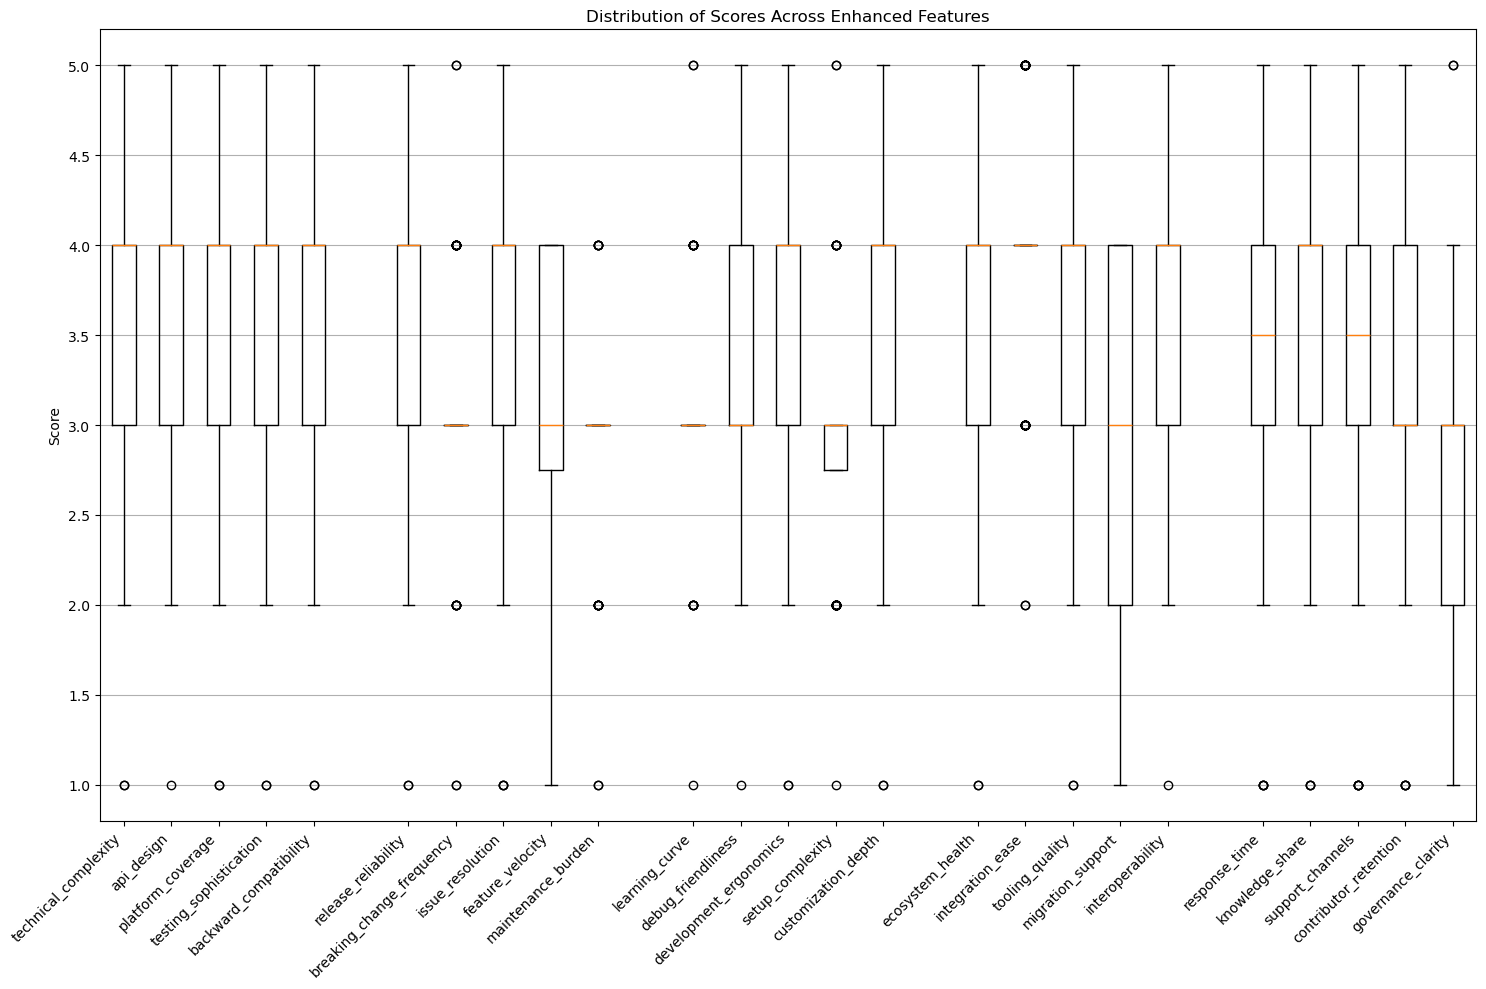

In [41]:
# Visualize the distribution of scores across new feature categories
import matplotlib.pyplot as plt
import seaborn as sns

# Create feature category groups
feature_groups = {
    'Technical': ['technical_complexity', 'api_design', 'platform_coverage', 
                 'testing_sophistication', 'backward_compatibility'],
    'Project Management': ['release_reliability', 'breaking_change_frequency',
                          'issue_resolution', 'feature_velocity', 'maintenance_burden'],
    'User Experience': ['learning_curve', 'debug_friendliness', 'development_ergonomics',
                       'setup_complexity', 'customization_depth'],
    'Ecosystem': ['ecosystem_health', 'integration_ease', 'tooling_quality',
                  'migration_support', 'interoperability'],
    'Community': ['response_time', 'knowledge_share', 'support_channels',
                 'contributor_retention', 'governance_clarity']
}

# Create visualization
plt.figure(figsize=(15, 10))
current_pos = 0
box_data = []
labels = []
positions = []

for group_name, features in feature_groups.items():
    group_data = []
    for feature in features:
        scores = [result[feature]['score'] 
                 for result in enhanced_results.values() 
                 if feature in result]
        if scores:
            group_data.append(scores)
            labels.append(feature)
            positions.append(current_pos)
            current_pos += 1
    current_pos += 1  # Add space between groups
    
    if group_data:
        box_data.extend(group_data)

plt.boxplot(box_data, positions=positions, labels=labels)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Scores Across Enhanced Features')
plt.ylabel('Score')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Save the enhanced analysis summary
with open('data2/enhanced_analysis_summary.json', 'w', encoding='utf-8') as f:
    json.dump({
        'averages': enhanced_summary,
        'total_projects': len(enhanced_results),
        'timestamp': str(pd.Timestamp.now())
    }, f, indent=2)

## Prepare Enhanced Features for XGBoost
Let's extract scores from our enhanced analysis and prepare them for the XGBoost model.


In [42]:
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Extract feature names (excluding key_features)
sample_result = next(iter(enhanced_results.values()))
feature_names = [k for k in sample_result.keys() if k != 'key_features']

# Create a list of dictionaries for DataFrame construction
feature_data = []
for project, result in enhanced_results.items():
    scores = {feature: result[feature]['score'] for feature in feature_names}
    scores['project'] = project  # Add project as identifier
    feature_data.append(scores)

# Create DataFrame with all columns
enhanced_df = pd.DataFrame(feature_data)
enhanced_df.set_index('project', inplace=True)

print(f"Created feature matrix with {len(feature_names)} features for {len(enhanced_df)} projects")
print("\nFeature names:")
print(feature_names)

Created feature matrix with 41 features for 104 projects

Feature names:
['technical_complexity', 'web3_focus', 'developer_tool', 'project_maturity', 'community_size', 'enterprise_ready', 'community_engagement', 'documentation', 'code_quality', 'status', 'corporate', 'security', 'innovation', 'performance', 'modularity', 'accessibility', 'dependency_complexity', 'api_design', 'platform_coverage', 'testing_sophistication', 'backward_compatibility', 'release_reliability', 'breaking_change_frequency', 'issue_resolution', 'feature_velocity', 'maintenance_burden', 'learning_curve', 'debug_friendliness', 'development_ergonomics', 'setup_complexity', 'customization_depth', 'ecosystem_health', 'integration_ease', 'tooling_quality', 'migration_support', 'interoperability', 'response_time', 'knowledge_share', 'support_channels', 'contributor_retention', 'governance_clarity']


In [43]:
# Prepare feature matrices for XGBoost
X = []  # Feature differences
y = []  # Target values (weight_a)

# For each comparison, compute feature differences
skipped = 0
for _, row in df[['project_a', 'project_b', 'weight_a']].iterrows():
    if row['project_a'] in enhanced_df.index and row['project_b'] in enhanced_df.index:
        # Compute feature differences between project pairs
        feature_diff = enhanced_df.loc[row['project_a']] - enhanced_df.loc[row['project_b']]
        X.append(feature_diff.values)
        y.append(row['weight_a'])
    else:
        skipped += 1

X = np.array(X)
y = np.array(y)

print(f"Created comparison matrix with {len(X)} pairs")
print(f"Skipped {skipped} comparisons due to missing projects")
print(f"Features shape: {X.shape}")

Created comparison matrix with 20958 pairs
Skipped 0 comparisons due to missing projects
Features shape: (20958, 41)


In [44]:
# Train XGBoost model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model with more careful parameters
xgb = XGBRegressor(
    max_depth=6,
    learning_rate=0.05,
    n_estimators=200,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

# Make predictions
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

# Print performance metrics
print("\nModel Performance:")
print(f"Training R2: {r2_score(y_train, y_pred_train):.4f}")
print(f"Testing R2: {r2_score(y_test, y_pred_test):.4f}")
print(f"Training MSE: {mean_squared_error(y_train, y_pred_train):.4f}")
print(f"Testing MSE: {mean_squared_error(y_test, y_pred_test):.4f}")



Model Performance:
Training R2: 0.6973
Testing R2: 0.6231
Training MSE: 0.0459
Testing MSE: 0.0563


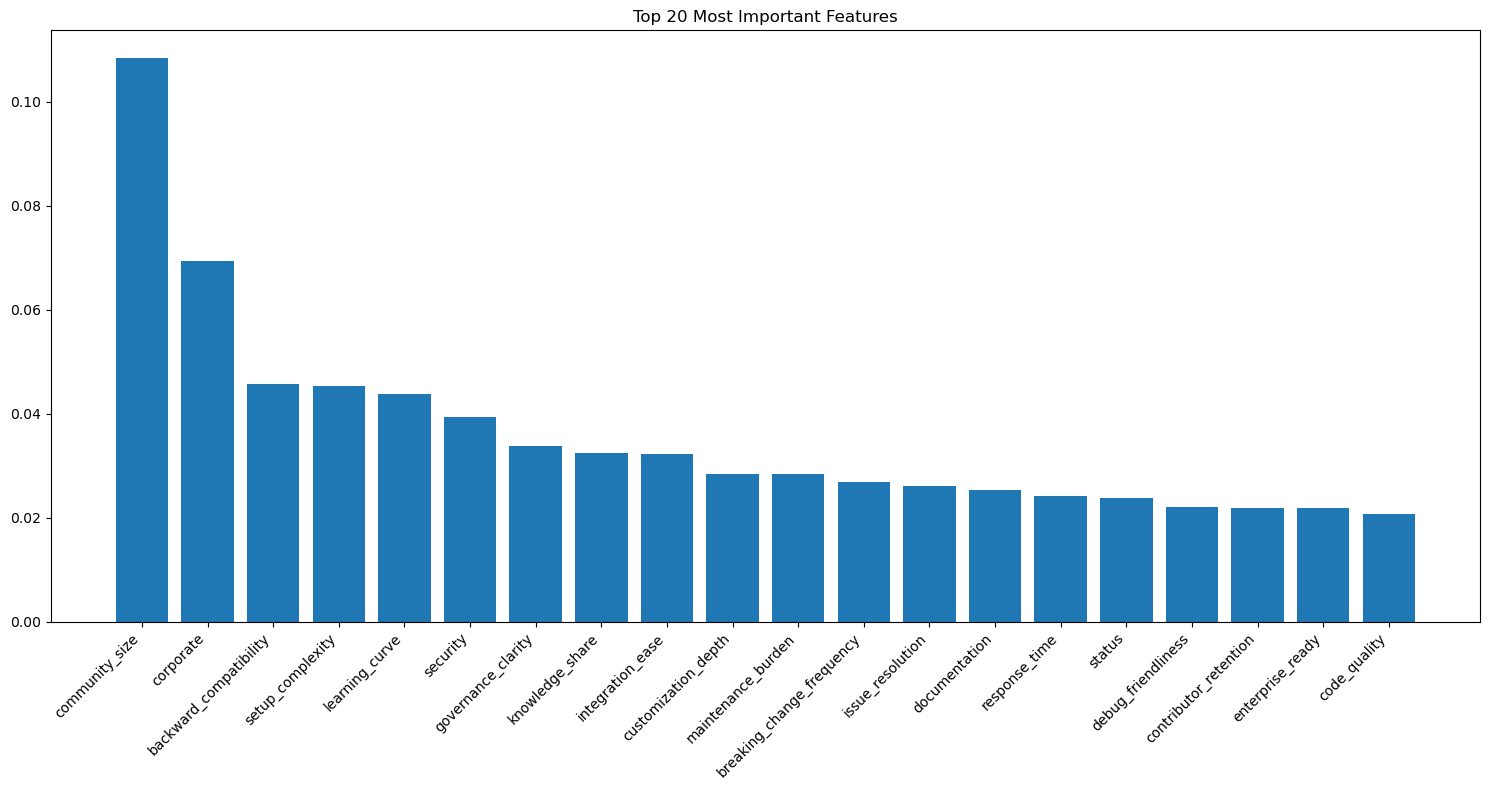


Top 10 Most Important Features:
                   feature  importance
4           community_size    0.108270
10               corporate    0.069322
20  backward_compatibility    0.045678
29        setup_complexity    0.045399
26          learning_curve    0.043837
11                security    0.039362
40      governance_clarity    0.033704
37         knowledge_share    0.032466
32        integration_ease    0.032313
30     customization_depth    0.028479


In [45]:
# Analyze feature importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb.feature_importances_
}).sort_values('importance',ascending=False)

# Plot feature importance
plt.figure(figsize=(15, 8))
plt.bar(importance_df['feature'][:20], importance_df['importance'][:20])
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string())


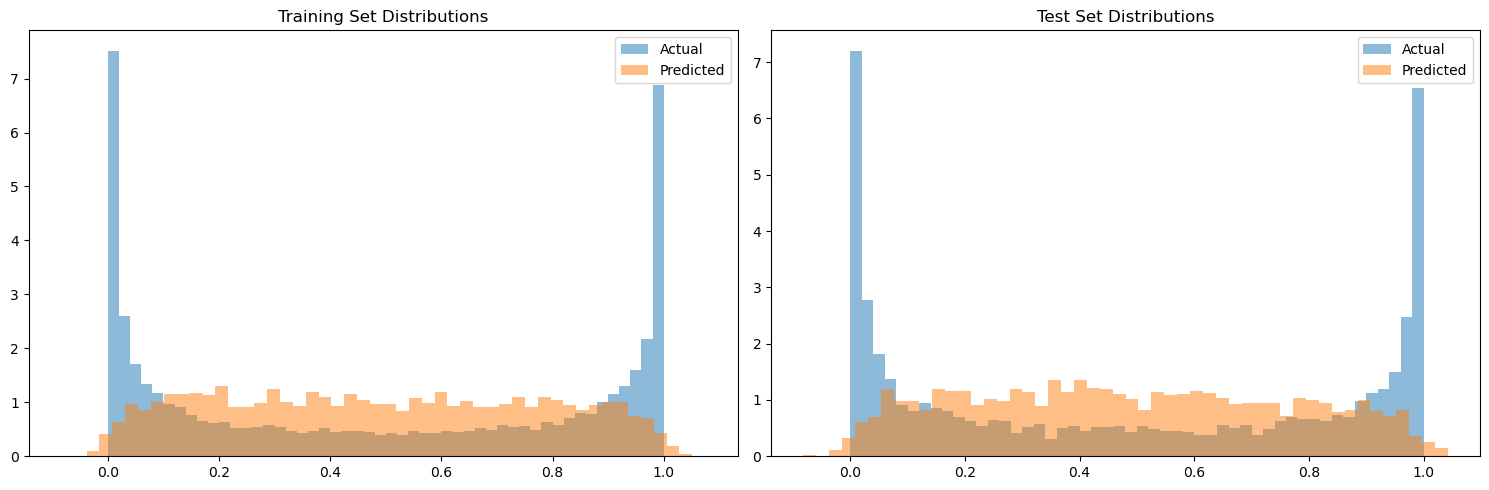


Distribution Statistics:

Training Set:
Actual  - Mean: 0.4878, Std: 0.3892
Predicted - Mean: 0.4879, Std: 0.2833

Test Set:
Actual  - Mean: 0.4855, Std: 0.3866
Predicted - Mean: 0.4839, Std: 0.2753


In [46]:
# Analyze prediction distributions
plt.figure(figsize=(15, 5))

# Training distribution
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=50, alpha=0.5, label='Actual', density=True)
plt.hist(y_pred_train, bins=50, alpha=0.5, label='Predicted', density=True)
plt.title('Training Set Distributions')
plt.legend()

# Test distribution
plt.subplot(1, 2, 2)
plt.hist(y_test, bins=50, alpha=0.5, label='Actual', density=True)
plt.hist(y_pred_test, bins=50, alpha=0.5, label='Predicted', density=True)
plt.title('Test Set Distributions')
plt.legend()

plt.tight_layout()
plt.show()

# Print distribution statistics
print("\nDistribution Statistics:")
print("\nTraining Set:")
print(f"Actual  - Mean: {y_train.mean():.4f}, Std: {y_train.std():.4f}")
print(f"Predicted - Mean: {y_pred_train.mean():.4f}, Std: {y_pred_train.std():.4f}")
print("\nTest Set:")
print(f"Actual  - Mean: {y_test.mean():.4f}, Std: {y_test.std():.4f}")
print(f"Predicted - Mean: {y_pred_test.mean():.4f}, Std: {y_pred_test.std():.4f}")

# Transform Data before prediction
Let's try different transformations to spread out our [0,1] data:
1. Logit transformation: logit(p) = log(p/(1-p))
2. Arctanh transformation: arctanh(2p-1)

We'll need to handle edge cases (0 and 1) carefully.


In [47]:
import numpy as np
from scipy.special import logit, expit

def transform_target(y, method='logit', epsilon=1e-10):
    """
    Transform target variable from [0,1] to (-inf,+inf)
    Args:
        y: Target values in [0,1]
        method: 'logit' or 'arctanh'
        epsilon: Small value to avoid log(0)
    """
    # Clip values to avoid numerical issues
    y_clipped = np.clip(y, epsilon, 1-epsilon)
    
    if method == 'logit':
        return logit(y_clipped)
    elif method == 'arctanh':
        return np.arctanh(2*y_clipped - 1)
    else:
        raise ValueError(f"Unknown method: {method}")

def inverse_transform_target(y_trans, method='logit'):
    """
    Transform predictions back to [0,1] range
    """
    if method == 'logit':
        return expit(y_trans)
    elif method == 'arctanh':
        return (np.tanh(y_trans) + 1) / 2
    else:
        raise ValueError(f"Unknown method: {method}")

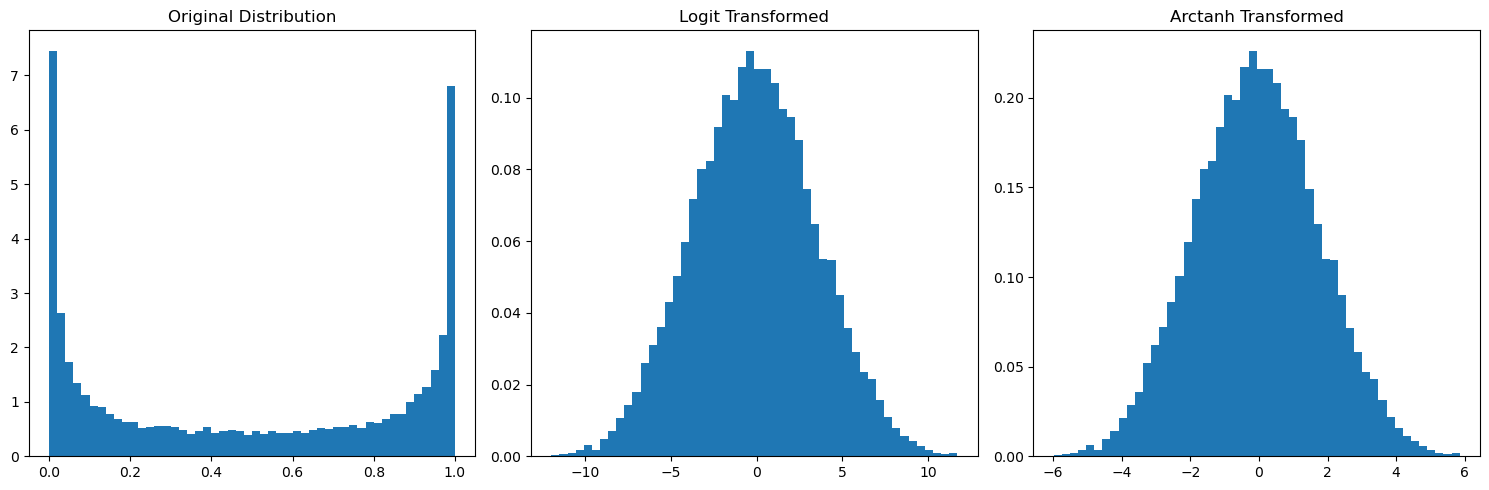

In [48]:
# Plot the transformations
y_orig = np.linspace(0.001, 0.999, 1000)
y_logit = transform_target(y_orig, 'logit')
y_arctanh = transform_target(y_orig, 'arctanh')

plt.figure(figsize=(15, 5))

# Original distribution
plt.subplot(1, 3, 1)
plt.hist(y, bins=50, density=True)
plt.title('Original Distribution')

# Logit transformed
plt.subplot(1, 3, 2)
plt.hist(transform_target(y, 'logit'), bins=50, density=True)
plt.title('Logit Transformed')

# Arctanh transformed
plt.subplot(1, 3, 3)
plt.hist(transform_target(y, 'arctanh'), bins=50, density=True)
plt.title('Arctanh Transformed')

plt.tight_layout()
plt.show()

In [49]:
# Train models with transformed targets
def train_and_evaluate(X_train, X_test, y_train, y_test, transform_method):
    """
    Train XGBoost with transformed targets and evaluate
    """
    # Transform targets
    y_train_trans = transform_target(y_train, transform_method)
    y_test_trans = transform_target(y_test, transform_method)
    
    # Train model
    xgb = XGBRegressor(
        max_depth=6,
        learning_rate=0.05,
        n_estimators=200,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    # Fit on transformed data
    xgb.fit(X_train, y_train_trans)
    
    # Make predictions and transform back
    y_pred_train = inverse_transform_target(xgb.predict(X_train), transform_method)
    y_pred_test = inverse_transform_target(xgb.predict(X_test), transform_method)
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    
    return {
        'model': xgb,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test
    }

# Train models with different transformations
results = {}
for method in ['logit', 'arctanh']:
    print(f"\nTraining with {method} transformation:")
    results[method] = train_and_evaluate(X_train, X_test, y_train, y_test, method)
    print(f"Training R2: {results[method]['train_r2']:.4f}")
    print(f"Testing R2: {results[method]['test_r2']:.4f}")
    print(f"Training MSE: {results[method]['train_mse']:.4f}")
    print(f"Testing MSE: {results[method]['test_mse']:.4f}")


Training with logit transformation:
Training R2: 0.6944
Testing R2: 0.6060
Training MSE: 0.0463
Testing MSE: 0.0589

Training with arctanh transformation:
Training R2: 0.6944
Testing R2: 0.6060
Training MSE: 0.0463
Testing MSE: 0.0589


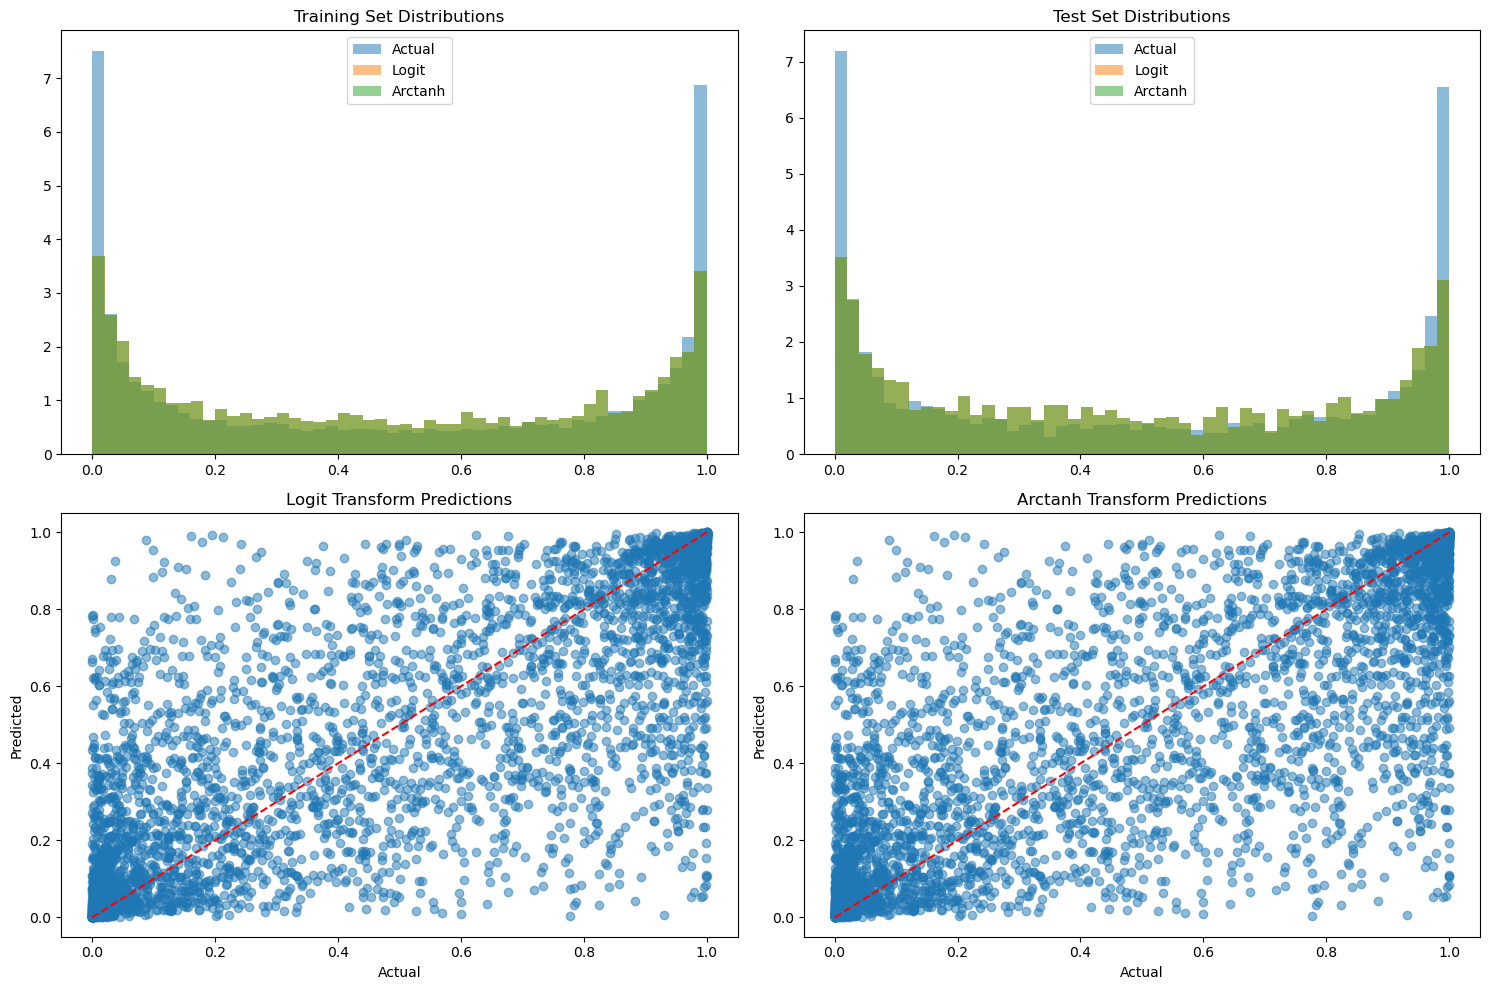

In [50]:
# Compare distributions of predictions
plt.figure(figsize=(15, 10))

# Training set comparisons
plt.subplot(2, 2, 1)
plt.hist(y_train, bins=50, alpha=0.5, label='Actual', density=True)
plt.hist(results['logit']['y_pred_train'], bins=50, alpha=0.5, label='Logit', density=True)
plt.hist(results['arctanh']['y_pred_train'], bins=50, alpha=0.5, label='Arctanh', density=True)
plt.title('Training Set Distributions')
plt.legend()

# Test set comparisons
plt.subplot(2, 2, 2)
plt.hist(y_test, bins=50, alpha=0.5, label='Actual', density=True)
plt.hist(results['logit']['y_pred_test'], bins=50, alpha=0.5, label='Logit', density=True)
plt.hist(results['arctanh']['y_pred_test'], bins=50, alpha=0.5, label='Arctanh', density=True)
plt.title('Test Set Distributions')
plt.legend()

# Scatter plots of predictions vs actual
plt.subplot(2, 2, 3)
plt.scatter(y_test, results['logit']['y_pred_test'], alpha=0.5, label='Logit')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Logit Transform Predictions')

plt.subplot(2, 2, 4)
plt.scatter(y_test, results['arctanh']['y_pred_test'], alpha=0.5, label='Arctanh')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Arctanh Transform Predictions')

plt.tight_layout()
plt.show()

## Generate Contest Predictions
We'll load the test file, generate predictions using our best model (transformed XGBoost),
and format the output according to contest requirements.


In [51]:
# Load test data
testset_path = repo_dir / "test.csv"
test_df = pd.read_csv(testset_path)
print(f"Loaded {len(test_df)} test pairs")

# Verify format
print("\nTest file columns:")
print(test_df.columns.tolist())

# Show a few rows
print("\nSample rows:")
print(test_df.head())

Loaded 4261 test pairs

Test file columns:
['id', 'project_a', 'project_b', 'total_amount_usd', 'funder', 'quarter']

Sample rows:
      id                         project_a  \
0  20884  https://github.com/rollup/rollup   
1  20885  https://github.com/rollup/rollup   
2  20886  https://github.com/rollup/rollup   
3  20887  https://github.com/rollup/rollup   
4  20888  https://github.com/rollup/rollup   

                                   project_b  total_amount_usd  \
0         https://github.com/webpack/webpack             29097   
1             https://github.com/babel/babel             26093   
2  https://github.com/sindresorhus/type-fest              4460   
3         https://github.com/inikulin/parse5              2454   
4        https://github.com/zloirock/core-js             13229   

           funder  quarter  
0  opencollective  2024-01  
1  opencollective  2024-01  
2  opencollective  2024-01  
3  opencollective  2024-01  
4  opencollective  2024-01  


In [52]:
# Prepare test features
X_predict = []
skipped_pairs = []

for idx, row in test_df.iterrows():
    if row['project_a'] in enhanced_df.index and row['project_b'] in enhanced_df.index:
        # Compute feature differences between project pairs
        feature_diff = enhanced_df.loc[row['project_a']] - enhanced_df.loc[row['project_b']]
        X_predict.append(feature_diff.values)
    else:
        skipped_pairs.append(idx)

X_predict = np.array(X_predict)

print(f"Prepared {len(X_predict)} pairs for prediction")
print(f"Skipped {len(skipped_pairs)} pairs due to missing features")


Prepared 3865 pairs for prediction
Skipped 396 pairs due to missing features


In [54]:
# Use our best model (transformed version) to make predictions
# Get transformed predictions
y_trans_pred = results['logit']['model'].predict(X_predict)

# Transform back to [0,1] range
y_pred = inverse_transform_target(y_trans_pred, 'logit')

# Cell 5 (code)
# Create submission dataframe
submission_df = test_df.copy()

# Add predictions
submission_df.loc[submission_df.index.difference(skipped_pairs), 'weight_a'] = y_pred
submission_df.loc[submission_df.index.difference(skipped_pairs), 'weight_b'] = 1 - y_pred

# For skipped pairs, use 0.5 as default
if skipped_pairs:
    submission_df.loc[skipped_pairs, 'weight_a'] = 0.5
    submission_df.loc[skipped_pairs, 'weight_b'] = 0.5

# Verify format
print("\nSubmission Statistics:")
print(f"Total pairs: {len(submission_df)}")
print(f"Mean weight_a: {submission_df['weight_a'].mean():.4f}")
print(f"Mean weight_b: {submission_df['weight_b'].mean():.4f}")
print("\nVerifying weights sum to 1:")
weight_sums = submission_df['weight_a'] + submission_df['weight_b']
print(f"Min sum: {weight_sums.min():.4f}")
print(f"Max sum: {weight_sums.max():.4f}")

# Save submission
submission_path = repo_dir / "submission.csv"
submission_df.to_csv(submission_path, index=False)
print("\nSaved submission to 'submission.csv'")
print("\nFirst few predictions:")
print(submission_df.head().to_string())


Submission Statistics:
Total pairs: 4261
Mean weight_a: 0.5353
Mean weight_b: 0.4647

Verifying weights sum to 1:
Min sum: 1.0000
Max sum: 1.0000

Saved submission to 'submission.csv'

First few predictions:
      id                         project_a                                  project_b  total_amount_usd          funder  quarter  weight_a  weight_b
0  20884  https://github.com/rollup/rollup         https://github.com/webpack/webpack             29097  opencollective  2024-01  0.052905  0.947095
1  20885  https://github.com/rollup/rollup             https://github.com/babel/babel             26093  opencollective  2024-01  0.025544  0.974456
2  20886  https://github.com/rollup/rollup  https://github.com/sindresorhus/type-fest              4460  opencollective  2024-01  0.220612  0.779388
3  20887  https://github.com/rollup/rollup         https://github.com/inikulin/parse5              2454  opencollective  2024-01  0.945144  0.054856
4  20888  https://github.com/rollup/rollup    

In [57]:
# Create submission dataframe with correct format
submission_df = pd.DataFrame()
submission_df['id'] = test_df['id']

# Add predictions
valid_indices = test_df.index.difference(skipped_pairs)
submission_df.loc[valid_indices, 'pred'] = y_pred
submission_df.loc[skipped_pairs, 'pred'] = 0.5

# Format to exactly 11 decimal places
submission_df['pred'] = submission_df['pred'].map(lambda x: '{:.11f}'.format(float(x)))

# Verify format
print("\nSubmission Statistics:")
print(f"Total pairs: {len(submission_df)}")
print("\nColumns:")
print(submission_df.columns.tolist())
print("\nSample rows:")
print(submission_df.head())

# Save submission
submission_path = "data2/submission.csv"
submission_df.to_csv(submission_path, index=False)
print("\nSaved submission to 'submission.csv'")

# Verify file contents
loaded = pd.read_csv(submission_path)
print("\nVerifying saved file:")
print("Columns:", loaded.columns.tolist())
print("Number of rows:", len(loaded))
print("Sample predictions (11 decimal places):")
print(loaded.head().to_string())


Submission Statistics:
Total pairs: 4261

Columns:
['id', 'pred']

Sample rows:
      id           pred
0  20884  0.05290514603
1  20885  0.02554371580
2  20886  0.22061197460
3  20887  0.94514423609
4  20888  0.18481831253

Saved submission to 'submission.csv'

Verifying saved file:
Columns: ['id', 'pred']
Number of rows: 4261
Sample predictions (11 decimal places):
      id      pred
0  20884  0.052905
1  20885  0.025544
2  20886  0.220612
3  20887  0.945144
4  20888  0.184818
